## 벤포드법칙(Benford's Law)와 이미지

### 개요

넷플릭스 <커넥티드 - 수의 법칙> 다큐를 보다가 벤포드의 법칙(Benford's Law)이라는게 있다는걸 알았다. 

![넷플릭스-커넥티드-수의법칙](./res/netflix_connected_benford.png)

**실세계에서 존재하는 많은 수치 데이터의 10진법 값에서 수의 첫째 자리의 확률 분포를 관찰한 결과, 첫째 자리 숫자가 작을 확률이 크다는 법칙이다.** 즉, 자연스럽게(인위적이지 않은) 생긴 임의의 숫자들이 아래와 같은 확률적인 분포를 띈다는 것이다.

![출처-위키](https://wikimedia.org/api/rest_v1/media/math/render/svg/8c95a1396d93b32a5036825d087e8c97a32e7c56)

![출처-위키](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Rozklad_benforda.svg/440px-Rozklad_benforda.svg.png)

처음 듣고 보는거라 이놈들이 어디서 또 약을 파나하면서 시청했는데 점점 빠져들었다. 회계에서 비공식적(?)으로 활용되기도 한단다. 가령, 엔론의 회계분식 장부에서는 인위적으로 맞춘듯한 수치들이 있어서 자연스럽지 못해 이 법칙에 어긋난다거나 하는 것들..

IT 분야에서는 이미지의 위조 혹은 딥페이크(Deep Fake) 영상을 탐지하는 연구에도 사용된다는 내용도 나왔는데, 이 부분이 나의 호기심을 자극했다. 그래서 나도 한번 직접 해보기로 했다.

자, 바로 이 노트를 하나 열어서.. (사실 바로 한건 아니고 삽질 좀 하고 정리하는 중..)

---
### Let's Go

**1. 일단, 벤포드법칙 그래프를 한번 그려보자**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def showbfplot(stat_labels=None):
    digits = np.arange(1, 10)
    benford_prob = np.array([
        0.3010,   # for 1
        0.1761,   # for 2
        0.1249,   # ..
        0.0969,
        0.0792,
        0.0669,
        0.0580,
        0.0512,
        0.0458,   # for 9 
    ])
    
    fig, ax = plt.subplots()
    ax.plot(digits, benford_prob, label='benford')
    if stat_labels:
        for s, l in stat_labels:
            ax.plot(digits, list(map(lambda t: t[1], s)), label=l)
    plt.legend()
    plt.show()

> *참고로, `showbfplot()`은 여러 데이터를 받아서 기준 benford 그래프와 비교해서 볼 수 있게 작성*

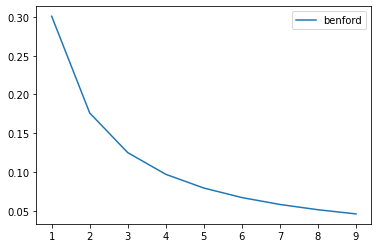

In [2]:
showbfplot()

그래! 시작이 좋군! 그럼 이미지의 각 픽셀들의 첫번째 숫자들의 빈도를 뽑아보면 이렇게 나온다는거지??

**2. 이미지를 로드해보자**

이미지 로드, 디스플레이를 할 수 있는 간단한 유틸리티 함수들을 정의하고,

In [3]:
import cv2

def to_color(img, code):
    return cv2.cvtColor(img, code)

def load_img(path):
    return to_color(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_RGB2BGR)

def showimg(img):
    plt.imshow(img, 'gray')

우리 아기사진을 불러와서 보자.

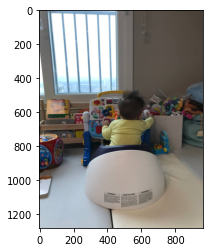

In [4]:
img = load_img('res/baby.jpg')
showimg(img)

잘 놀고 있는게 보인다. 그럼 이 사진의 각 픽셀 값(10진수)의 첫번째 숫자를 가져와서 통계를 뽑으면 된다는거지?

**3. 픽셀값의 첫번째 숫자 빈도를 구해보자**

In [5]:
from decimal import Decimal

import collections

first_digits = []
for x in np.nditer(img):
    if x == 0:
        continue

    _, digits, _ = Decimal(abs(float(x))).as_tuple()
    first_digits.append(str(digits[0]))

first_digits_counter = collections.Counter(first_digits)
first_digits_counter

Counter({'1': 1724989,
         '7': 352821,
         '8': 274128,
         '9': 119199,
         '2': 666602,
         '6': 232861,
         '5': 134234,
         '4': 88131,
         '3': 90428})

각 숫자의 빈도의 확률(Percentage)를 변경해서,

In [6]:
total = sum(first_digits_counter.values())
stats = sorted(map(lambda t: (int(t[0]), float(t[1]) / total), first_digits_counter.items()))
stats

[(1, 0.46831521914712876),
 (2, 0.18097498692102634),
 (3, 0.024550190544424665),
 (4, 0.02392658073683693),
 (5, 0.03644302956540342),
 (6, 0.0632191569023452),
 (7, 0.09578695512534231),
 (8, 0.07442268582255546),
 (9, 0.03236119523493692)]

그리고 차트로 그려보면,

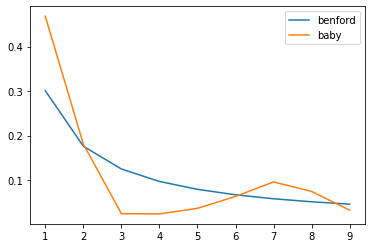

In [7]:
showbfplot([
    (stats, 'baby')
])

음.. 뭔가 나오는거 같긴 한데 좀 이상하다. 5부터는 오히려 값이 커지기도 하고.. 한번 흑백(Grayscale)로 해볼까?

**4. 다른 색상에 대해서 해보기**

일단 자주 쓰게 될 것 같으니까 빈도 구하는 루틴을 함수로 만들어 놓자.

In [8]:
def calc_benford_stats(np_array):
    first_digits = []
    for x in np.nditer(np_array):
        if x == 0:
            continue
        
        _, digits, _ = Decimal(abs(float(x))).as_tuple()
        first_digits.append(str(digits[0]))
        
    total = len(first_digits)
    first_digits_counter = collections.Counter(first_digits)

    total = sum(first_digits_counter.values())
    return sorted(map(lambda t: (int(t[0]), float(t[1]) / total), first_digits_counter.items()))

이미지 컬러를 흑백으로 바꾼 후 보면,

In [9]:
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

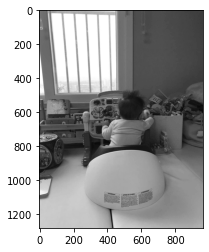

In [10]:
img_gray = to_gray(img)
showimg(img_gray)

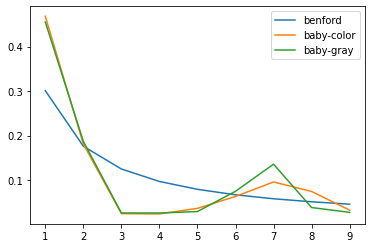

In [11]:
showbfplot([
    (calc_benford_stats(img), 'baby-color'),
    (calc_benford_stats(img_gray), 'baby-gray')
])

컬러 이미지의 분포와 크게 다를바가 없다. 혹시 YCbCr은 어떨까?

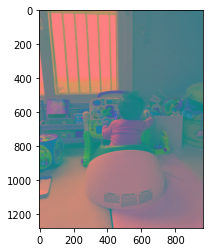

In [12]:
img_yxx = to_color(img, cv2.COLOR_BGR2YCrCb)
showimg(img_yxx)

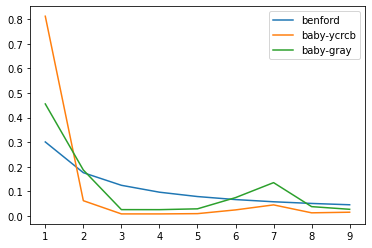

In [13]:
showbfplot([
    (calc_benford_stats(img_yxx), 'baby-ycrcb'),
    (calc_benford_stats(img_gray), 'baby-gray')
])

더 안 좋아진 것 같다. 아무래도 RGB, Grayscale, YCxCx의 수치 범위가 0~255로 좁다보니 숫자들의 Variance가 좋지 못한 것 같다.

뭐가 더 없을까? (여기서 한참을 웹서핑..)

**5. 좀 더 벤포드그래프에 가까운 방법을 찾아보자. (Variance가 좋은 숫자를 찾아라!)**

(다시 돌아와서) JPEG Encoding 과정 중에 있는 DCT(Discrete Cosine Transform) 후의 결과가 -1024~1024라고 한다. 이거 왠지 느낌이 좋다.

일단 DCT를 하는 루틴을 정의해보자. ([이런데서](https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html) 긁어옴)

In [14]:
from numpy import r_

import numpy as np
import scipy.fftpack

def to_dct(img):
    def dct2d(a):
        return scipy.fftpack.dct(scipy.fftpack.dct(a, axis=0, norm='ortho'), axis=1, norm='ortho')

    imgsize = img.shape
    dct = np.zeros(imgsize)

    bs = 8
    for i in r_[:imgsize[0]:bs]:
        for j in r_[:imgsize[1]:bs]:
            dct[i:(i+bs),j:(j+bs)] = dct2d(img[i:(i+bs),j:(j+bs)])
           
    thresh = 0.0
    return dct * (abs(dct) > (thresh*np.max(dct)))

def showdct(dct):
    dct_img = np.uint8(dct) * 255.0
    plt.imshow(dct_img, interpolation='nearest')

이제 위의 아기 이미지에서 DCT Coefficients를 뽑아내서 벤포드 통계를 내보자.

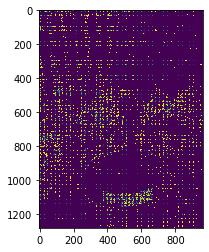

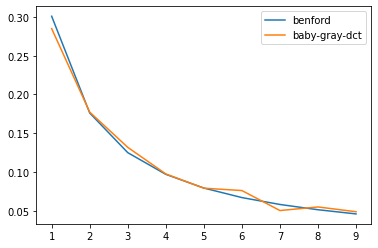

In [15]:
dct = to_dct(img_gray)
showdct(dct)

showbfplot([
    (calc_benford_stats(dct) , 'baby-gray-dct')
])

오우, 이럴수가! 뭔가 그럴싸하게 나왔다. 혹시 YCrCb에 대해서는 어떨까?

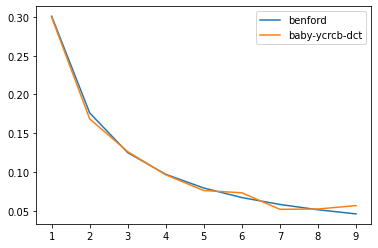

In [16]:
dct = to_dct(img_yxx)

showbfplot([
    (calc_benford_stats(dct) , 'baby-ycrcb-dct')
])

더 잘 들어 맞는 것 같다. 이거 말이 되나.. 더 다양한 이미지로 한번 해볼까?

**6. 더 다양한 이미지들에 대해서 테스트를 해보자**

코드 쓰기 귀찮으니까 숏컷 함수를 하나 만들고 가자.

In [17]:
import re

def show_me_benford(img_path):
    fig = plt.figure(figsize=(8, 8))
    
    fig.add_subplot(2, 1, 1)
    img = load_img(img_path)
    showimg(img)
    
    fig.add_subplot(2, 1, 2)
    img_yxx = to_color(img, cv2.COLOR_BGR2YCrCb)
    dct = to_dct(img_yxx)
    showdct(dct)
    
    stat = calc_benford_stats(dct)
    label = re.split('/|\.', img_path)[1]
    showbfplot([(stat, label)])

def show_me_bendford2(*img_paths):
    def stat_label_pair(path):
        img = load_img(path)
        
        img_yxx = to_color(img, cv2.COLOR_BGR2YCrCb)
        dct = to_dct(img_yxx)
        
        stat = calc_benford_stats(dct)
        label = re.split('/|\.', path)[1]
        
        return (stat, label)
 
    showbfplot([stat_label_pair(path) for path in img_paths])

일단, 수지를 빼놓을 수 없지.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


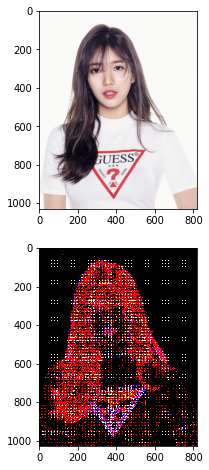

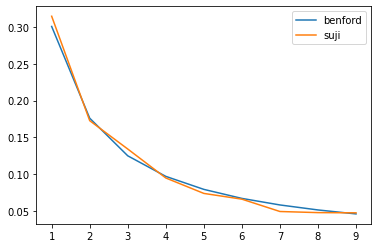

In [18]:
show_me_benford('res/suji.jpg')

굿! 이번엔 역사와 전통의 레나는 어떨까?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


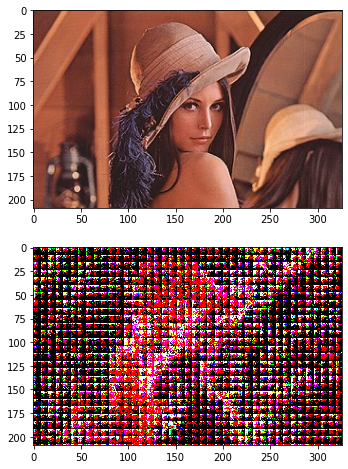

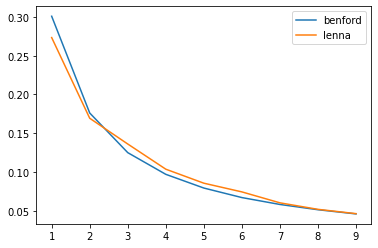

In [19]:
show_me_benford('res/lenna.jpg')

좋구요! 자연 이미지는 어떨까?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


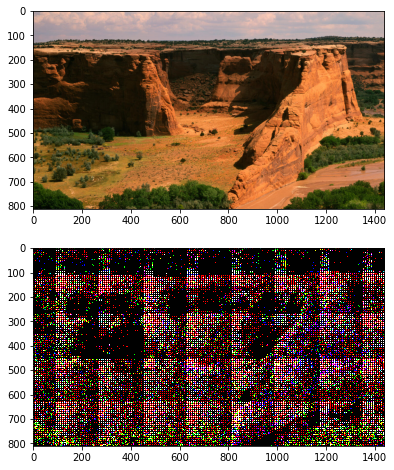

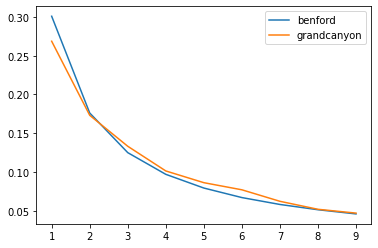

In [20]:
show_me_benford('res/grandcanyon.jpg')

이것도 얼추 나오는 것 같다. 컴퓨터 스샷은 어떨까?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


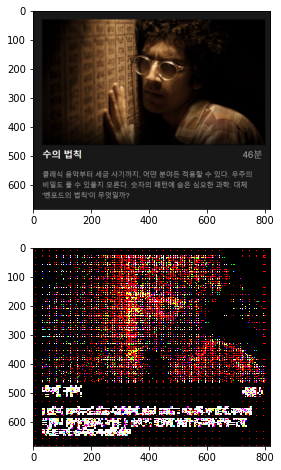

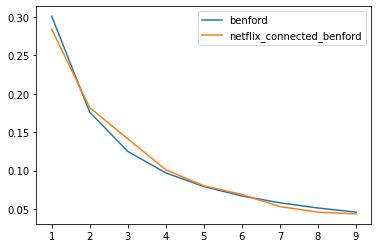

In [21]:
show_me_benford('res/netflix_connected_benford.png')

되네.. 내가 직접 그린 그림은 어떨까?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


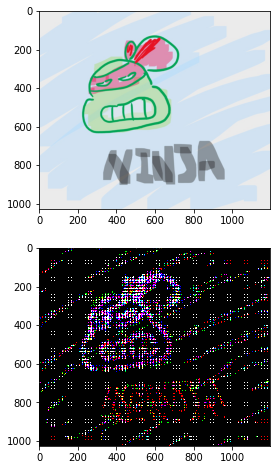

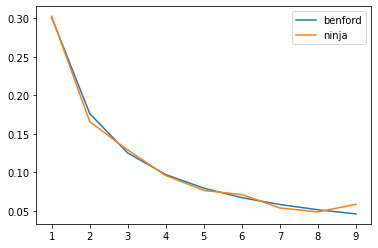

In [22]:
show_me_benford('res/ninja.jpg')

헉.. 심지어 더 fit 한 것 같은 기분.

여기까지 정리해보면,
- 이미지를 YCrCb 변환 후 DCT를 적용한 결과에서
- 각 DCT Coeffient 값의 첫째 자리 숫자의 빈도를 뽑아보니
- 벤포드 법칙에 맞아들어가더라
- 인물, 자연, 스샷, 직접 그린 이미지에 대해서도 그러하다

그럼 이 시점에서, 다큐에서 나왔던 벤포드법칙을 이용한 이미지의 위조 탐지가 가능한지 한번 실험해볼까? 

**7. 벤포드법칙을 이용한 이미지의 위조를 탐지하기**

위조한 이미지는 뭔가 수정한 후에 저장되었을 것이기 때문에
- 두번 이상 저장이 됐다거나
- 그 과정 중에 이미지의 퀄리티까 떨어졌을 가능성이 크다

이 두 종류에 대해서 마찬가지로 그래프를 뽑아보자

그럼 벤포드그래프와 가장 근사하게 나온 수지 이미지로 위의 리터치(re-touched)된 이미지를 준비해본다.

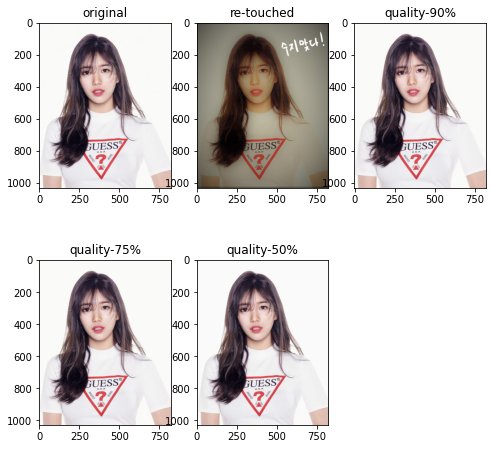

In [23]:
suji_orig = load_img('res/suji.jpg')
suji_retouched = load_img('res/suji-retouched.jpg')
suji_qual_90 = load_img('res/suji-quality-90.jpg')
suji_qual_75 = load_img('res/suji-quality-75.jpg')
suji_qual_50 = load_img('res/suji-quality-50.jpg')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 3, 1)
ax.title.set_text('original')
showimg(suji_orig)

ax = fig.add_subplot(2, 3, 2)
ax.title.set_text('re-touched')
showimg(suji_retouched)

ax = fig.add_subplot(2, 3, 3)
ax.title.set_text('quality-90%')
showimg(suji_qual_90)

ax = fig.add_subplot(2, 3, 4)
ax.title.set_text('quality-75%')
showimg(suji_qual_75)

ax = fig.add_subplot(2, 3, 5)
ax.title.set_text('quality-50%')
showimg(suji_qual_50)

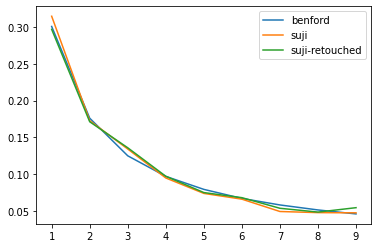

In [24]:
show_me_bendford2(
    'res/suji.jpg',
    'res/suji-retouched.jpg',
)

원본과 리터치한 이미지 사이에 큰 차이가 없다. 별로 변별력이 없네.. 퀄리티에 따른 차이도 보자.

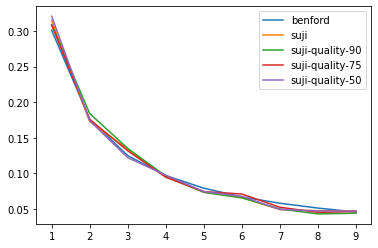

In [25]:
show_me_bendford2(
    'res/suji.jpg',
    'res/suji-quality-90.jpg',
    'res/suji-quality-75.jpg',
    'res/suji-quality-50.jpg',
)

흠.. 퀄리티에 따라서도 큰 차이를 없다.

### 결론

이미지 종류, 재저장 여부, 퀄리티에 따라 구분할 수 있는 차이가 아주 크게 있으면 좋겠다하고 내심 기대했었는데 단번에 알아차릴만한 큰 차이가 없었다. 반전이라면 반전인가..

하지만 아주 미세하게 차이가 있는 부분도 보인다. 만약 오차범위나 그런것들에 대한 데이터가 어느정도 쌓여있다면, 이것으로 이미지가 수정되었다고 판단할 수도 있을 것 같긴 하다.

무엇보다 핵심은 디지털 이미지의 성분도 벤포드 법칙을 따르고 있다는 사실.

### 참고

https://abhayk1201.github.io/files/EE604_tp.pdf
https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/node231.html#:~:text=answer%3A%20They%20define%20DC%20and,can%20be%20precomputed%20and%20stored.
https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html